### Load data

In [146]:
import pandas as pd
predictions = pd.read_csv("./data/predictions_2.csv")
predictions.head()

,label,predGbt,predReg,predReg_up
0,0,0.009072,0.001822,0.006424
1,0,0.015390,0.003476,0.011655
2,0,0.014491,0.001711,0.005634
3,0,0.017840,0.048812,0.193536
4,0,0.013194,0.002407,0.008383


### Calibration error

In [147]:
import math
def calibrationError(predictions, modelName, bucketSize = 100):
    count, sumPrediction, sumLabel = 0, 0, 0
    bucketFraudRate = []
    bucketPrediction = []
    bucketErrors = []
    for index, row in predictions.sort_values(by=[modelName]).iterrows():
        sumLabel = sumLabel + row["label"]
        sumPrediction = sumPrediction + row[modelName]
        count = count + 1
        if(count == bucketSize):
            predMean = sumPrediction / float(bucketSize)
            fraudRate = sumLabel / float(bucketSize)
            bucketFraudRate.append(fraudRate)
            bucketPrediction.append(predMean)
            bucketErrors.append(math.sqrt((predMean-fraudRate)*(predMean-fraudRate)))
            count, sumPrediction, sumLabel = 0, 0, 0

    return (bucketFraudRate, bucketPrediction, sum(bucketErrors) / float(len(bucketErrors)))

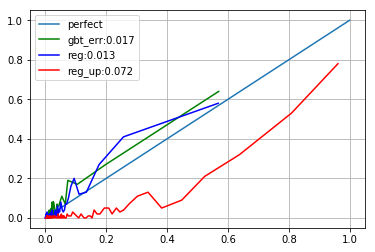

In [148]:
fraudRate_gbt, scores_gbt, err_gbt = calibrationError(predictions, "predGbt")
fraudRate_reg, scores_reg, err_reg = calibrationError(predictions, "predReg")
fraudRate_regup, scores_regup, err_regup = calibrationError(predictions, "predReg_up")
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot([0, 1], [0, 1], label = "perfect")
plt.plot(scores_gbt, fraudRate_gbt, color = 'g', label = "gbt_err:{:.3f}".format(err_gbt))
plt.plot(scores_reg, fraudRate_reg, color = 'b', label = "reg:{:.3f}".format(err_reg))
plt.plot(scores_regup, fraudRate_regup, color = 'r', label = "reg_up:{:.3f}".format(err_regup))
plt.legend()
plt.grid()
plt.show()

### Calibration algorithm

In [149]:
def trainCalibration(predictions, modelName, bucketSize = 100):
    count, sumLabel = 0, 0
    buckets = []
    for index, row in predictions.sort_values(by=[modelName]).iterrows():
        sumLabel = sumLabel + row["label"]
        count = count + 1
        if(count == bucketSize):
            fraudRate = sumLabel / float(bucketSize)
            buckets.append((row[modelName], fraudRate))
            count, sumLabel = 0, 0
    
    buckets.append((1,1))
    return buckets

In [150]:
def getCalibratedProb(p, calibBuckets):
    i = 0
    final_p = 0
    while(p > calibBuckets[i][0]):
        final_p = calibBuckets[i][1]
        i = i+1
    return final_p

In [159]:
predictions_train = pd.read_csv("./data/predictions_train_2.csv")

In [165]:
calibGbt = trainCalibration(predictions_train, "predGbt")
predictions["calibGbt"] = predictions["predGbt"].map(lambda x: getCalibratedProb(x, calibGbt))
calibrationError(predictions, "calibGbt")[2]))

Error after calib:0.017566666666666675


In [161]:
calibReg = trainCalibration(predictions_train, "predReg")
predictions["calibReg"] = predictions["predReg"].map(lambda x: getCalibratedProb(x, calibReg))
calibrationError(predictions, "calibReg")[2]

0.011725806451612902

In [162]:
calibReg_up = trainCalibration(predictions_train, "predReg_up")
predictions["calibReg_up"] = predictions["predReg_up"].map(lambda x: getCalibratedProb(x, calibReg_up))
calibrationError(predictions, "calibReg_up")[2]

0.02350215053763442